# Goos-Hanchen experiment
***

This notebook contains the data reduced from the usual Larmor Mantid reduction file. The experiment took place at Larmor beamline at ISIS from Nov 14-20th 2023. The reduced data is also contained in this github repository along with copies of the experiment log and pictures of the physical setup.

While the goal is to measure the Goos-Hanchen spatial shift of the two neutron spin states, it seems at the moment that we can only experimentally measure the phase shift between the two spin states. Again, the issue of the intrinsic coherence length of neutron pops up: Quan has shown some interesting potentially-observable effects in the different regiemes, but it is unclear how to exactly experimentally produce his proposed setups.

***
### Sample information
The two identical samples (assuming natural abundances) consist of the following layers with scattering length densities (SLDs) given in units of 10^-6 A^-2:
1. 50 nm Ti, SLD = -1.910
2. 50 nm Fe-Co-V 50-48-2%:
   1. Nuclear: SLD = 5.121
   2. Magnetic: SLD = -5.451 and 5.409
   3. Total: SLD = -0.33 and 10.53
4. 50 nm Si, SLD = 2.073
5. 50 nm Fe-Co-V 50-48-2%
6. 100 nm Ni-Mo 88-12% (non-magnetic), SLD = 8.52
7. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

The sample can be magnetized in a ~200 G field.

We also have two identical non-magnetic blanks:
1. 100 nm Ni-Mo 88-12%
2. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

***
### Problems/questions:
1. The film's easy axis and the plane of incidence are orthogonal: therefore, the beam size on target will be cut in half if we want the remnant mangetization to be parallel to the guide field at the sample position (vertical direction)
   1. ~~We can stack the two films back-to-back to create a better return loop for the magnetic flux lines at the sample position.~~
   2. ~~We can also try wrapping the sample in a thin layer of iron foil to close the flux loop.~~
   3. After discussion, we think that this will not be a problem because the sample is so thin, the dipole field should fall to zero quickly enough to be negligible.
2. Which detector should we use?
3. Does the position of the sample stack change the echo?
4. Do we need a slit after the sample?
   1. Yes, to remove the direct beam

***
### Current experimental plan:
1. Mount and measure the blank
   1. Critical edge at .01 A^-1
   2. Want the max signal to be at 4 AA, gives grazing angle of ??? and maximum beam width of 0.4 mm
2. Mount and measure the magnetic sample with poleshoes at 90 degrees (i.e. NSE mode)
   1. Need a very tight resolution (kHz ?) 
   2. Tight divergence, no more than 0.02 degrees?
3. Rotate the sample by 90 degrees (M parallel to guide field) and redo measurement
4. Change poleshoe angle to introduce splitting in the transverse horizontal direction
5. Put phase grating after the sample
   1. The grating may act like a "Goos-Hanchen" analyzer, meaning that we could tell the difference between the phase shift and spatial shift
   2. Can use the old "compass mount" from the coherence measurement for the grating

## Functions and constants

In [102]:
import numpy as np
import sympy as sym
import scipy as sc
import sympy as sym
import matplotlib.pyplot as plt
import scienceplots
import csv

plt.style.use(['science','notebook', 'grid','default','bright'])
SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 15,18,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size

sym.init_printing()

DEFAULT_PLOT_PARMS = {'title':'','xlab':'','ylab':'','multi_plot':True,'size':(8,5),'lw':3,\
                     'ls':'--'}  #mutliplot not implemented yet
SLD_PLOT_PARMS = DEFAULT_PLOT_PARMS|{'xlab':'Depth [AA]','ylab':'SLD [1e-6 AA^-2]','labels':['']}
THETA_C_PARMS = DEFAULT_PLOT_PARMS|{'xlab':r'$\lambda$ [AA]','ylab':r'$\theta_c$ [deg]',\
                                    'labels':['nuc','up','down','blank'],'ls':'-'}

def plot_function(xdata,ydata,plot_parms=DEFAULT_PLOT_PARMS):
    '''General function to plot given data.'''
    assert len(xdata) == len(ydata), 'Len mismatch between x and y data!'
    fig,ax = plt.subplots(figsize=plot_parms['size'])
    
    for indx,(x,y) in enumerate(zip(xdata,ydata)):
        ax.plot(x,y,plot_parms['ls'],linewidth=plot_parms['lw'],label=plot_parms['labels'][indx])
    ax.set(title=plot_parms['title'],xlabel=plot_parms['xlab'],ylabel=plot_parms['ylab'])
    if plot_parms['labels'] is not None: plt.legend()

    plt.grid()
    plt.tight_layout()
    plt.show()

## Analytic calculations

In [ ]:
def get_su2_state(theta=0,phi=0,alpha=None,beta=None,gamma=0):
    '''Returns spin state, either with the usual parameterization or two complex numbers.'''
    if alpha is None or beta is None:
        result = [sym.cos(theta/2),sym.sin(theta/2)*sym.exp(sym.I*phi)]
    else:
        norm = sym.sqrt(sym.abs(alpha)**2 + sym.abs(beta)**2)
        result = 1/norm*[alpha,beta]
    return sym.exp(sym.I*gamma)*sym.Matrix(result).applyfunc(sym.simplify)

def get_op(a=0,b=0,c=0,d=0):
    '''Returns general operator in terms of the pauli vector.'''
    result = a*sym.eye(2) + b*sym.Matrix([[0,1],[1,0]]) + \
    c*sym.Matrix([[0,-sym.I],[sym.I,0]]) + d*sym.Matrix([[1,0],[0,-1]])
    return result.applyfunc(sym.simplify)

def get_proj(op,sign=1):
    '''Returns up/down projection operator.'''
    assert sign == -1 or sign == 1, 'The sign must be +/-1.'
    return (sym.Rational(1,2)*(sym.eye(2) + sign*op)).applyfunc(sym.simplify)

def expect(lstate,op,rstate=None,force_real=True):
    '''Returns the expectation value from the given state and operator.'''
    if rstate is None: rstate = lstate
    result = (lstate.H*op*rstate)[0]
    if force_real: result = sym.re(result)
    return result.simplify()

def change_basis(op,new):
    '''Returns operator in new basis.'''
    return (new.inv()*op*new).applyfunc(sym.simplify)

def time_av(func,var,N=1):
    '''Returns time average over N periods'''
    integral = func.integrate((var,-sym.pi*N,sym.pi*N))
    return (integral/(2*sym.pi*N)).expand().simplify()

p0,p1,p2,t1,t2,P1,P2,P = sym.symbols(r'\phi_0,\phi_1,\phi_2,\theta_1,\theta_2,\Phi_1,\Phi_2,\Phi',real=True)
idt,spx,spy,spz = get_op(a=1),get_op(b=1),get_op(c=1),get_op(d=1)

#asummes the magnetization is along the x-direction and incident polarization is along z
x_cob = 1/sym.sqrt(2)*sym.Matrix([[1,1],[1,-1]])
interaction = change_basis(sym.diag(1,sym.exp(sym.I*P)),x_cob)
print('Interaction matrix:')
display(interaction.applyfunc(sym.simplify))

In [ ]:
print('Evolution of the spin states:')
psi0 = get_su2_state(theta=sym.pi/2,phi=0)  #phi_0=0 for incident polarization along x-direction
display('Initial state:',psi0)
psi1 = get_op(a=(1+sym.exp(sym.I*t1))/2,d=(1-sym.exp(sym.I*t1))/2)*psi0
display('First arm:',psi1)
psi2 = interaction*psi1
display('After interaction:',psi2)
psi3 = get_op(a=(1+sym.exp(-sym.I*t2))/2,d=(1-sym.exp(-sym.I*t2))/2)*psi2
display('Second arm:',psi3)

In [ ]:
Pols = []
print('Final polarization components')
for i,k in zip(['Px','Py','Pz'],[spx,spy,spz]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols.append(pk)  #saving this value
    print('At echo, theta_1 = theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

In [ ]:
Pols2 = []
print('Final polarization components')
for i,k in zip(['P_+x','P_-x','P_x'],[get_proj(spx,sign=1),get_proj(spx,sign=-1),spx]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols2.append(pk)  #saving this value
    print('When theta_1 = -theta_2')
    pk = pk.subs(t2,-t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

In [ ]:
nm,theta,phi,gam = sym.symbols(r'n_m,\theta,\phi,\gamma',real=True)  #general interaction matrix calculation
c1,c2 = get_su2_state(theta=theta,phi=phi,gamma=gam),\
        get_su2_state(theta=sym.pi-theta,phi=phi+sym.pi,gamma=-gam)
gen_basis = sym.Matrix(np.hstack([c1,c2]))
display(gen_basis)
display(gen_basis := gen_basis.subs(((theta,sym.pi/2),(phi,sym.pi/2),(gam,sym.pi/4))))

gen_mag = change_basis(spz,gen_basis).applyfunc(sym.simplify)
display(gen_mag)

#display(gen_mag)

## Numerical reflectivity calculations

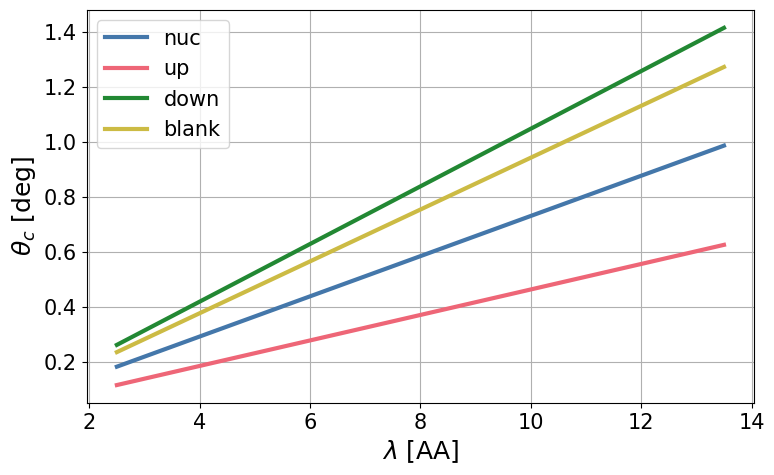

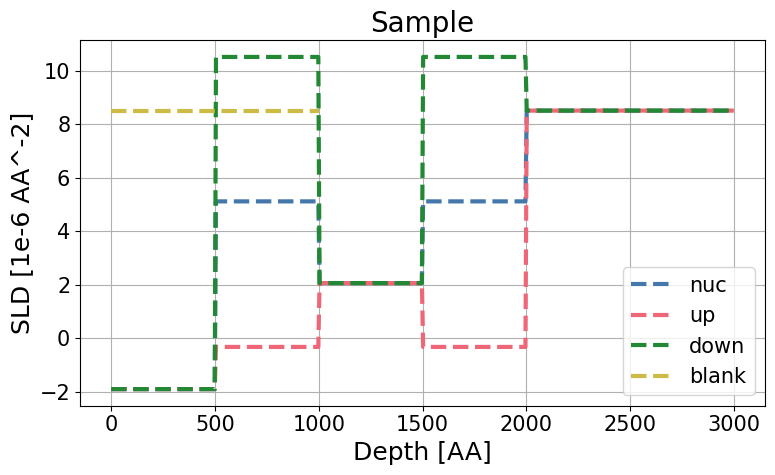

In [39]:
LAMS = np.linspace(2.5,13.5,300)  #nominal wavelength range on Larmor

def get_crit(SLD,lam=LAMS,degrees=True):
    '''Returns critical angle.'''
    result = np.arcsin(lam*np.sqrt(SLD*10**-6/np.pi))
    if degrees: result *= 180/np.pi
    return result

def get_pot(SLDs=[],ts=[],plot=False,plot_parms=SLD_PLOT_PARMS):
    '''Returns the potential given the thicknesses and SLDs of each layer.
    Doesn't include substrate.'''
    total_x = np.linspace(0,np.sum(ts),500)
    steps = np.array([np.sum(ts[:i]) for i in range(len(ts)+1)])
    potential = np.sum([SLDs[indx]*((steps[indx]<=total_x)&(total_x<=steps[indx+1])) for indx in range(len(SLDs))],axis=0)
    if plot: plot_function([total_x],[potential],plot_parms)
    return potential,total_x

SLDs = {'Ti':-1.910,'FeCoV_nuc':5.121,'FeCoV_up':-0.33,'FeCoV_down':10.53,'Si':2.06,'NiMo':8.52,\
       'exp_FeCoV_up':0.26961,'exp_FeCoV_down':9.93501}
sample_ts = np.array([50.,50.,50.,50.,100.])*10  #convert to Angstroms
blank_ts = np.array([100.])*10

sample_nuc_SLDs = [SLDs['Ti'],SLDs['FeCoV_nuc'],SLDs['Si'],SLDs['FeCoV_nuc'],SLDs['NiMo']]
sample_up_SLDs = [SLDs['Ti'],SLDs['FeCoV_up'],SLDs['Si'],SLDs['FeCoV_up'],SLDs['NiMo']]
sample_down_SLDs = [SLDs['Ti'],SLDs['FeCoV_down'],SLDs['Si'],SLDs['FeCoV_down'],SLDs['NiMo']]
blank_SLDs = [SLDs['NiMo']]

sample_tc = get_crit(sample_nuc_SLDs[1]),get_crit(sample_up_SLDs[2]),get_crit(sample_down_SLDs[1])
blank_tc = get_crit(blank_SLDs[0])
plot_function([LAMS for i in range(4)],[*sample_tc,blank_tc],plot_parms=THETA_C_PARMS)

sample_nuc,X = get_pot(sample_nuc_SLDs,ts=sample_ts,\
                       plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down')})
sample_up,_ = get_pot(sample_up_SLDs,ts=sample_ts,\
                      plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up')})
sample_down,_ = get_pot(sample_down_SLDs,ts=sample_ts,\
                        plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('down')})
blank,Xb = get_pot(blank_SLDs,ts=blank_ts,\
                   plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('blank')})

plot_function([X,X,X,Xb],[sample_nuc,sample_up,sample_down,blank],\
              plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down','blank')})

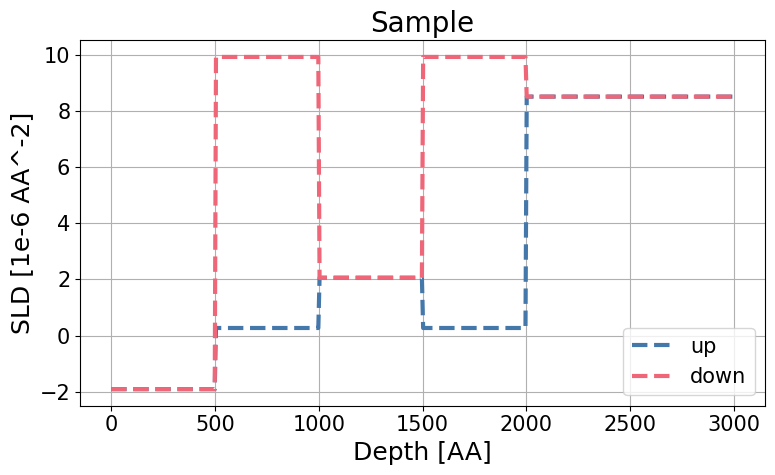

In [52]:
sample_up_SLDs = [SLDs['Ti'],SLDs['exp_FeCoV_up'],SLDs['Si'],SLDs['exp_FeCoV_up'],SLDs['NiMo']]
sample_down_SLDs = [SLDs['Ti'],SLDs['exp_FeCoV_down'],SLDs['Si'],SLDs['exp_FeCoV_down'],SLDs['NiMo']]

sample_up,_ = get_pot(sample_up_SLDs,ts=sample_ts,\
                      plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up')})
sample_down,_ = get_pot(sample_down_SLDs,ts=sample_ts,\
                        plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('down')})
plot_function([X,X],[sample_up,sample_down],\
              plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up','down')})

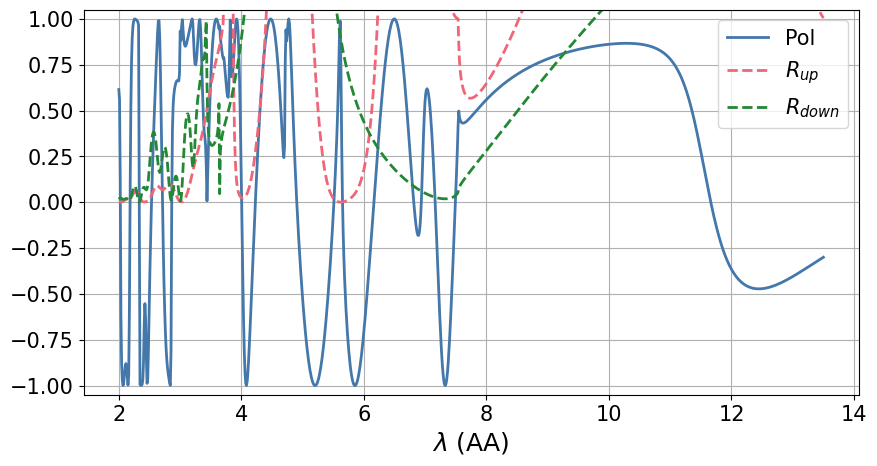

"GH_shift = wavelengths[1:]**2*np.cos(theta*np.pi/180)*np.diff(phase)/(2*np.pi)\nplt.figure(figsize=(10,5))\nplt.plot(wavelengths,phase,'--',label=r'$\\Phi$',lw=2,color='C0')\nplt.plot(wavelengths[1:],GH_shift,'-',label='GH-shift',lw=2,color='C1')\nplt.xlabel(r'$\\lambda$ (AA)')\nplt.legend()\nplt.grid()\nplt.show()"

In [56]:
def get_t_matrix(SLDs,ts,k0=.314,substrate=SLDs['Si']):
    '''Given a potential, returns the transfer matrix. Assumes air for z<=0 and 
    an additional infinite-thickness substrate layer.'''
    assert len(SLDs) == len(ts), 'Check number of layers!'
    km = [np.emath.sqrt(k0**2 - 4*np.pi*rho*1e-6) for rho in [0.]+SLDs+[substrate]]
    ms = len(km)  #air 0, layers (1,...,N), substrate N+1
    
    phim = [0]+[km[i]*ts[i] for i in range(ms-2)]  #phi_0 special case
    
    tm = [2*km[i]/(km[i] + km[i+1]) for i in range(ms-1)]
    rm = [(km[i] - km[i+1])/(km[i] + km[i+1]) for i in range(ms-1)]

    Rm = [np.array([[1,rm[i]],[rm[i],1]]) for i in range(ms-1)]
    Cm = [1/tm[i]*np.diag((np.exp(-1j*phim[i]),np.exp(1j*phim[i])))@Rm[i] for i in range(ms-1)]

    t_matrix = np.identity(2)
    for C in Cm:
        t_matrix = np.matmul(t_matrix,C)
    return t_matrix

def get_R_Phi(t_up,t_down=None):
    '''Calculates reflectivity (R) and phase (Phi) from t-matrix entries.'''
    R_up = np.abs(t_up[:,1,0])**2/np.abs(t_up[:,0,0])**2
    result = [R_up]
    if t_down is not None:
        R_down = np.abs(t_down[:,1,0])**2/np.abs(t_down[:,0,0])**2
        result.append(R_down)
        result.append(np.angle(t_up[:,1,0]/t_up[:,0,0]) - np.angle(t_down[:,1,0]/t_down[:,0,0]))
    return result

theta = .35*np.pi/180  #scattering angle
wavelengths = np.linspace(2,13.5,1000)

t_up = np.array([get_t_matrix(sample_up_SLDs,sample_ts,k0=2*np.pi*theta/w) for w in wavelengths])
t_down = np.array([get_t_matrix(sample_down_SLDs,sample_ts,k0=2*np.pi*theta/w) for w in wavelengths])
R_up,R_down,phase = get_R_Phi(t_up,t_down)

plt.figure(figsize=(10,5))
plt.plot(wavelengths,np.cos(phase),'-',label='Pol',lw=2,color='C0')
plt.plot(wavelengths,R_up,'--',label='$R_{up}$',lw=2,color='C1')
plt.plot(wavelengths,R_down,'--',label='$R_{down}$',lw=2,color='C2')
#plt.plot(wavelengths,R_nuc,'--',label='$R_{nuc}$',lw=2,color='C1')
#plt.plot(wavelengths,R_blank,'--',label='$R_{blank}$',lw=2,color='C2')
plt.xlabel(r'$\lambda$ (AA)')
plt.ylim(-1.05,1.05)
plt.legend()
plt.grid()
plt.show()

'''GH_shift = wavelengths[1:]**2*np.cos(theta*np.pi/180)*np.diff(phase)/(2*np.pi)
plt.figure(figsize=(10,5))
plt.plot(wavelengths,phase,'--',label=r'$\Phi$',lw=2,color='C0')
plt.plot(wavelengths[1:],GH_shift,'-',label='GH-shift',lw=2,color='C1')
plt.xlabel(r'$\lambda$ (AA)')
plt.legend()
plt.grid()
plt.show()'''

## Experiment log
***

### 11/14 Day One (Tuesday)
Setup and calibration of the beamline.

* 9:30
* We decided that the magnetization of the sample will probbaly not be a problem because the sample is so thin. Therefore we will not worry about the mismatch of the sample field direction and the guide field direction.
* Still need to magnetize the sample today and finish the sample holder.

* 2:00
* Found the echo before lunch, need to finish building the sample holder and check the echo as we scan the sample stage (should only need a few mm of drive)
* Should we use a supermirror or a blank for tuning echo?
* Aligning the sample slit with the transmission monitor

* 7:00
* Decided to run echo scans overnight to test the long-term stability of the echo point because we cannot retune the echo once we put the magnetic sample in the beam. Also included a scan of the sample stack translation.
* Tomorrow need to write down all of the slit distances and aperture sizes.

### 11/15 Day Two (Wednesday)
Mounting the blank with NO longitudinal splitting. (and the sample)

* 10:30
* Echo stability was very stable overnight for all positions of the sample stack. Above 80% for 3-10 AA.
* Leveled the sample stack (+/- 0.1 degrees for both directions)
* Adjusted the sample center of rotation to be the same center of rotation of the second arm (within few cms).
* Finding the center of the beam using a piece of Cd taped to the Al sample holder
* By eye using laser, the center is at 27 mm and 58.25 degrees
* Laser beam and neutron beam are off by 0.4 mm using the monitor right after the sample position (center 26.6 mm using neutrons, add 0.8 mm to include the thickness of the sample)
* Increasing the beam height did not change the tune (25 mm at the front, 40 mm at the sample)
* Collimation from pipe 31 mm
* Snout aperture 30 mm height 30 mm width (yes, it is that wide)
  

* 11:00
* Pixel 34 is the center of the beam at the moment (0.64 mm per pixel)
* 41004,41005 are the spectra numbers
  

* 1:00
* Magnetized the sample, wrote the field direction on the Al plate. Went to above 0.027 Tesla
* Found the critical edge to be at 0.39 degrees??? (or 0.35???)

* 3:00
* The blank appears to be curved. The beam is spread over 8 pixels instead of 4 as before.
*   

* 5:00
* Aperture width is still 2 mm wide
* Magnetic sample agrees well with Victor's model assuming 89% magnetization. This value agrees more closely with the 
* Going to measure the magnetic sample overnight

* 9:00
* Forgot to get beamline parameters. Need to interrograte Rob and Victor tomorrow to get them
* Also need to copy the plots to the log book

### 11/16 Day Three (Thursday)

* 10:00
* Magnetic sample ran successfully overnight. Improving statistics on the blank until after lunch. Will update the logbook today
* Need to check the parameters from Victor's fits

* 8:00
* Magnetic sample rotated by 90 degrees replicated the original polarization except now the signal is cos(phi) instead of 1/2*(1 + cos(phi))
* Going to run this orientation overnight and add the grating in tomorrow

### 11/17 Day Four (Friday)

* 11:00
* Added the grating after the sample (GR27, 2 um period, 10.5 um depth, 560 nm groove width)
* Sample still in the vertical direction
* Doubled-checked where the instrument parameters are stored. They appear in the log book under "Analysis/Property/Run".
  * Pre-sample slit: 0.5 mm by 25 mm
  * Post sample slit: ??? mm by 25 mm
  * Need to record the sample and slit positions manually
* Updated and sent out logbook, will consider running another grating?

### 11/18 Day Five (Saturday)

* 10:00
* Running with grating before sample until 2:00 pm to compare with the sample only run
* After that, we'll get better statistics for the P0 run before changing the incident angle to shift the GH bump in the polarization to appear at shorter wavelengths
* The journal viewer title was wrong for some runs. The correct naming is
  * 79130 - 79142 No grating
  * 79143 - 79144 Grating after sample
  * 79145 - 79159 Grating before sample
  * 79160 - ... Grating after sample (again)

* 11:30
* Going to measure the broken samples with X-rays (don't know the roughness numbers)
* Got the fitting functon for P0 to work, need to port the q function as well
* The new data seems show that the grating was slightly tilted about the vertical axis or that the P0 has slightly declined (more likely grating angle misalignment because peak heights are still tall)

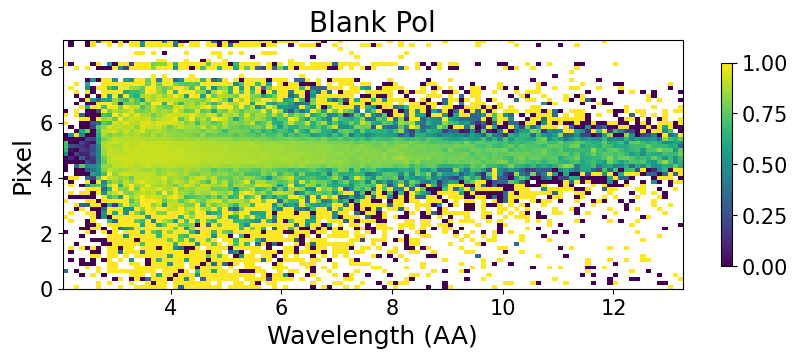

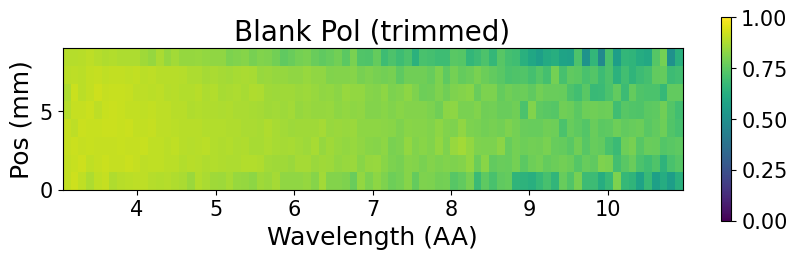

In [385]:
DEFAULT_PATH = 'C:\\Users\\samck\\Documents\\GitHub\\Goos-Hanchen\\reduced_data\\'
def load_data(file,path=DEFAULT_PATH):
    '''Loads the mantid output data into numpy array.'''
    with open(path+file) as f:
        temp = f.readlines()[2:-2]
        temp = [l.replace('\n','').split(',') for l in temp]
        x = np.array([float(temp[x][0]) for x in range(len(temp))])
        y = np.array([float(temp[y][1]) for y in range(len(temp))])
        e = np.array([float(temp[y][2]) for y in range(len(temp))])
    return x,y,e

def load_data_2D(file,path=DEFAULT_PATH):
    '''Loads the mantid output data into numpy 2D array.
    Returns X, Y, and E coordinate arrays, and pixel name.'''
    with open(path+file) as f:
        lines = f.readlines()[1:]
        lines = [l.replace('\n','').split(',') for l in lines]
        pnames,xs,ys,es = [],[],[],[]  #pixel name from DAC
        for l in lines:
            if len(l) != 3: pnames.append(l[0])
            else:
                xs.append(float(l[0]))
                try:
                    ys.append(float(l[1]))
                    es.append(float(l[2]))
                except Exception:
                    ys.append(np.NaN)  #dumbass Mantid stuff
                    es.append(np.Inf)
        lnum,pnum = len(lines),len(pnames)  #tof pixels, spatial pixels
        new_shape = (len(pnames),(len(lines)-len(pnames))//len(pnames))
    return np.array(xs).reshape(new_shape),np.array(ys).reshape(new_shape),np.array(es).reshape(new_shape),pnames

def trim_arr(arrays,segments):
    '''Applied the same trim to a list of arrays. First array determines
    the trimming for the other arrays.'''
    result = []
    masks = np.array([(s[0]<arrays[0]) & (arrays[0]<s[1]) for s in segments])
    
    new_pix_nums = masks[0].shape[0],np.sum(masks[0],axis=1)[0] #number of new vertical and horizontal pixels
    for a in arrays:
        for m in masks:
            a = a[m]
        result.append(a)
    return [r.reshape(new_pix_nums) for r in result]

chubby = np.polynomial.chebyshev.Chebyshev.fit
get_chubby = np.polynomial.chebyshev.chebval

#xt,yt,et = trim_arr([x,y,e],[(4,11)])
#file = "Thu_P0.txt"
#x,y,e = load_data(file)

file = "Thu_P0_2D.txt"
X,Y,E,pname = load_data_2D(file)
PIXELS = [0,39-30]

plt.figure(figsize=(10,8))
plt.title('Blank Pol')
plt.imshow(Y,origin='lower',vmin=0,vmax=1,extent=[X[0,0],X[0,-1],PIXELS[0],PIXELS[-1]],aspect=.5)
plt.ylabel('Pixel')
plt.xlabel('Wavelength (AA)')
plt.colorbar(shrink=.33)
plt.show()

Xt,Yt = trim_arr((X,Y),[(3,11)])
Yt = Yt[31:39,:]  #choosing detector pixels
plt.figure(figsize=(10,8))
plt.title('Blank Pol (trimmed)')
plt.imshow(Yt,origin='lower',vmin=0,vmax=1,extent=[Xt[0,0],Xt[0,-1],PIXELS[0],PIXELS[-1]],aspect=.2)
plt.ylabel('Pos (mm)')
plt.xlabel('Wavelength (AA)')
plt.colorbar(shrink=.33)
plt.show()

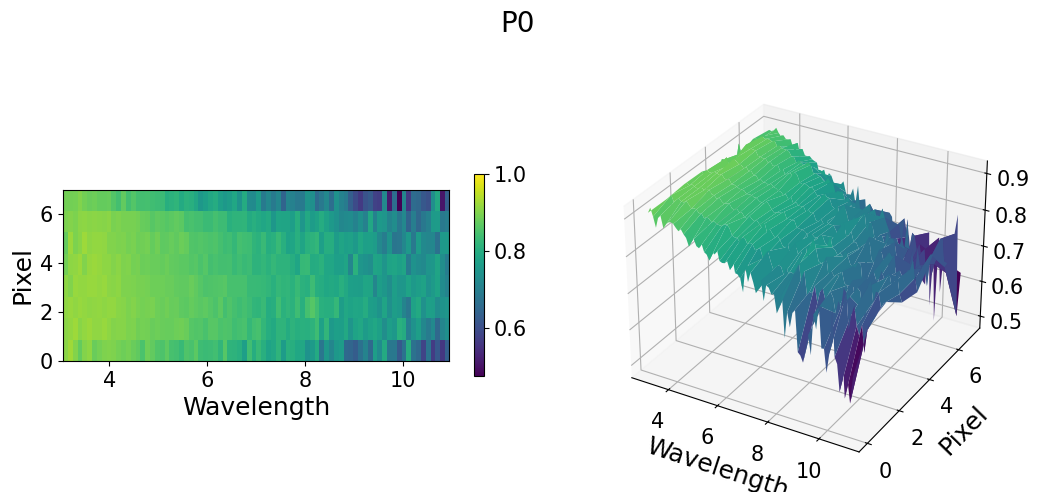

In [399]:
from matplotlib import cm
def show_image(image,x,y,title=None,x_label=None,y_label=None,vmin=None,vmax=None,\
              size=(11,5),shrink=.5,aspect=.5,phi=-60,theta=30):
    """Plots the given 2D image with a heat map and interactive 3D plot."""
    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(1,2,1)
    im1 = ax1.imshow(image,origin='lower',vmin=vmin,vmax=vmax,aspect=aspect,extent=(x[0],x[-1],y[0],y[-1]))
    plt.colorbar(im1,ax=ax1,shrink=shrink)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    ax2 = fig.add_subplot(1,2,2,projection='3d')
    ax2.view_init(elev=theta, azim=phi, roll=0)
    X,Y = np.meshgrid(x,y)
    im2 = ax2.plot_surface(X,Y,image,cmap=cm.viridis,vmin=vmin,vmax=vmax)
    #plt.colorbar(im2,ax=ax2,shrink=shrink,pad=.1)
    ax2.set_xlabel(x_label,labelpad=7.)
    ax2.set_ylabel(y_label,labelpad=7.)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_image(Yt,Xt[0,:],np.arange(8),title='P0',x_label='Wavelength',y_label='Pixel',vmax=1)

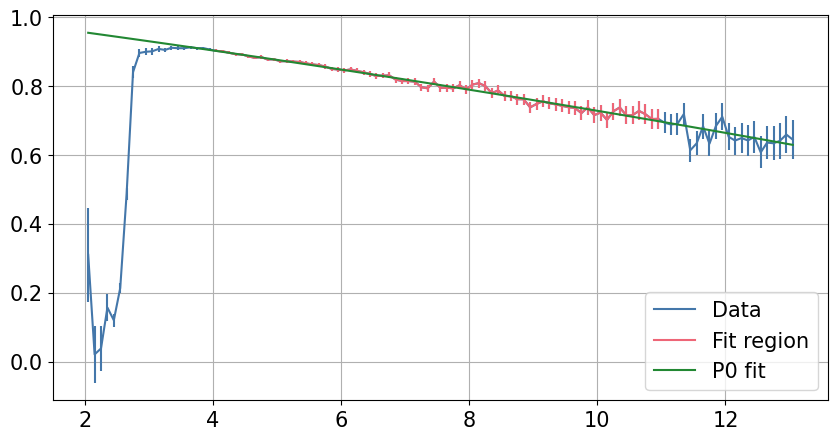

In [362]:
file = "Thu_P0.txt"
x,y,e = load_data(file)

plt.figure(figsize=(10,5))
plt.plot(x,y,color='C0',label='Data')
plt.errorbar(x,y,e,color='C0',ls='none',zorder=5)

plt.plot(xt,yt,color='C1',label='Fit region')
plt.errorbar(xt,yt,et,color='C1',ls='none',zorder=5)

fitted = get_chubby(x,chubby(xt,yt,2,w=1/et).convert().coef)
plt.plot(x,fitted,color='C2',zorder=10,label='P0 fit')

plt.legend()
plt.grid()
plt.show()

### 11/19 Day Six (Sunday)

* 9:00
* Overnight data looks good. The peak shifted from ~8.5 A to 11 A as expected
* Running with grating before the sample, will run until 8 pm tonight, then put the grating after the sample to finish through the night.
* 

### 11/20 Day Seven (Monday)

* Enjoying Oxford!

## Testing space
***